In [2]:
import pandas as pd
import numpy as np

In [3]:
data = pd.read_csv("/home/tgraham/Documents/MSC/project_data/new_approach_data.csv",index_col=0)

In [4]:
data = data.drop(columns=["ActualCompletionDateTime","ExtractTimestamp","JobID","CentralAssetID"])

In [5]:
data = data.rename(columns={"prefix":"Region","ParameterValueID":"%Full","Previous_pvalue":"Previous_%Full"})

In [8]:
data.Region.unique()

array(['NW13', 'NW10', 'SW21', 'EA68', 'MD09', 'SE04', 'SO03', 'NE12'],
      dtype=object)

In [9]:
data["RouteID"] = data["RouteID"].astype(str)
data["Region"] = data["Region"].astype(str)
data["%Full"] = data["%Full"].astype(str)
data["Days_Since_Maintenance"] = data["Days_Since_Maintenance"].astype(int)

In [10]:
data["%Full"].unique()

array(['0-25', '2550', '7510', '5075', 'CLEA'], dtype=object)

In [11]:
data["Region"].value_counts()

SW21    141253
NW13    120936
NW10     75395
EA68     47733
SE04     24511
MD09      2117
NE12       938
SO03       177
Name: Region, dtype: int64

In [12]:
def edit_paramaterValueID (value):
    param_dict = {
        "CLEA":0,
        "0-25":1,
        "2550":2,
        "5075":3,
        "7510":4
    }
    return param_dict[value]

In [13]:
def encode_type_of_maintenance(value):
    if value == "Non-Emptying":
        return 0
    elif value == "Emptying":
        return 1
    else:
        pass

In [14]:
def encode_region(value):
    if value == 'SW21':
        return 1
    elif value == 'NW13':
        return 2
    elif value == 'NW10':
        return 3
    elif value == 'EA68':
        return 4
    elif value == 'SE04':
        return 5
    elif value == 'MD09':
        return 6
    elif value == 'NE12':
        return 7 
    elif value == 'SO03':
        return 8
    else:
        pass

In [15]:
data["%Full"] = data["%Full"].apply(edit_paramaterValueID)
data["Previous_%Full"] = data["Previous_%Full"].apply(edit_paramaterValueID)
data["Previous_type_of_maintenance"] = data["Previous_type_of_maintenance"].apply(encode_type_of_maintenance)
data["Region"] = data["Region"].apply(encode_region)

In [16]:
data = data.drop(columns="RouteID")

In [17]:
def reduce_cardinality_of_dsm(days):
    if days >= 0 and days <=90:
        return int(0)
    elif days > 90 and days <= 180:
        return int(1)
    elif days > 180 and days <= 270:
        return int(2)
    elif days > 270 and days <= 360:
        return int(3)
    elif days > 360 and days <= 450:
        return int(4)
    elif days > 450 and days <= 540:
        return int(5)
    elif days > 540 and days <= 630:
        return int(6)
    elif days > 630 and days < 720:
        return int(7)
    elif days >= 720:
        return int(8) 

In [18]:
struct_data = data

In [19]:
struct_data["Months_Since_Maintenance"] = struct_data["Days_Since_Maintenance"].apply(reduce_cardinality_of_dsm)

In [20]:
struct_data["Months_Since_Maintenance"].value_counts()

2    91475
1    76611
3    72704
4    71057
0    41073
5    29521
6    12869
7     9770
8     7980
Name: Months_Since_Maintenance, dtype: int64

In [21]:
struct_data = struct_data.drop(columns="Days_Since_Maintenance")

In [22]:
struct_data = struct_data.drop(columns="FloodHotspot")

In [23]:
struct_data = struct_data.drop(columns="Failure_or_Maintenance")

In [24]:
struct_data

,%Full,Region,full_failure,covered_failure,broken_failure,Previous_%Full,Previous_type_of_maintenance,Months_Since_Maintenance
15458,1,2,0,0,0,1,1,0
15460,2,2,0,0,0,2,1,0
15462,2,2,0,0,0,2,1,0
15464,2,2,0,0,0,2,1,0
15466,2,2,0,0,0,2,1,0
...,...,...,...,...,...,...,...,...
551199,4,3,0,0,0,2,1,2
551200,4,3,0,0,0,2,1,2
551201,2,1,0,0,0,3,0,2
551202,2,1,0,0,0,3,0,2


# Modelling

# Gcastle

In [25]:
import os
os.environ['CASTLE_BACKEND'] = 'pytorch'

from collections import OrderedDict

import numpy as np
import networkx as nx

import castle
from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from castle.datasets import IIDSimulation, DAG
from castle.algorithms import PC, GES, ICALiNGAM, GOLEM
from castle.common.priori_knowledge import PrioriKnowledge
import matplotlib.pyplot as plt

2023-07-28 12:24:47,067 - /home/tgraham/.local/lib/python3.8/site-packages/castle/algorithms/__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.


## PC

In [347]:
# Build the model
pc = PC(variant='stable',alpha=0.8) #,priori_knowledge=priori,alpha=0.8)
pc.learn(struct_data)

# Print out the learned matrix
print(pc)

KeyboardInterrupt: 

In [344]:
from causallearn.graph.Dag import Dag
from causallearn.graph.Edge import Edge
from causallearn.graph.Endpoint import Endpoint
from causallearn.graph.GraphNode import GraphNode
import networkx as nx


def create_dag_from_gcastle(graph_object,data):
    """
    This function takes a gcastle dag object and returns a causal learn graph so we can use the causal learn plotting function
    """
    
    try:
        # Convert it to a directioned dag
        learned_graph = nx.DiGraph(graph_object.causal_matrix)
    except:
        pass
    # Extract edges
    required_edges_indexes = list(learned_graph.edges)
    # Create mapping from indexes to namex
    MAPPING = {k: v for k, v in zip(range(len(data.columns)), list(data.columns.values))}
    # Apply mapping
    required_edges = []
    for item in required_edges_indexes:
        required_edges.append([MAPPING[item[0]],MAPPING[item[1]]])
    
    # Define DAG
    node_names = struct_data.columns
    nodes = []
    for name in node_names:
        node = GraphNode(name)
        nodes.append(node)
    dag = Dag(nodes)
    
    # Add edges
    for item in required_edges:
        node1 = dag.get_node(item[0])
        node2 = dag.get_node(item[1])
        dag.add_directed_edge(node1, node2)
    
    return dag

In [87]:
dag = create_dag_from_gcastle(pc,struct_data)

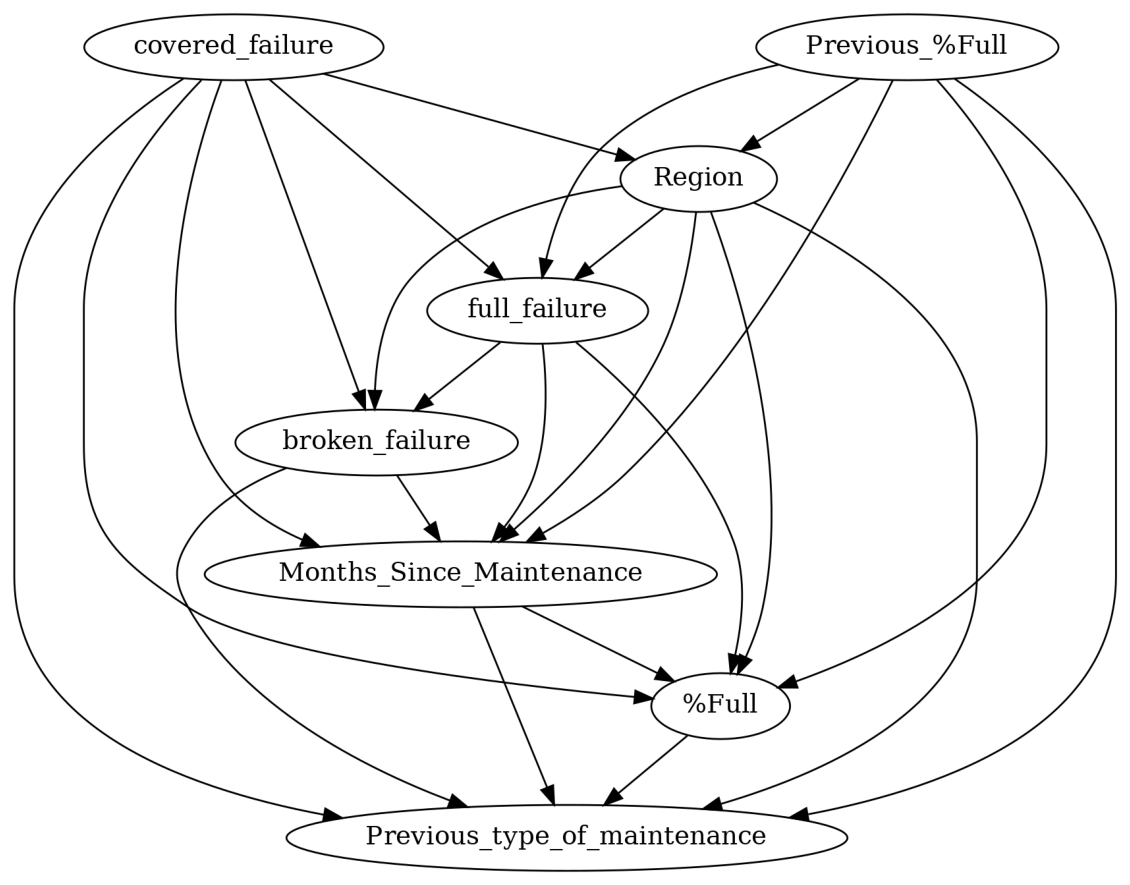

In [88]:
# Visualization using pydot
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io
pyd = GraphUtils.to_pydot(dag,labels=list(struct_data.columns.values))
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(img)
plt.show()

## LINGAM

In [91]:
from castle.algorithms import DirectLiNGAM

# DirectLiNGAM learn
g = DirectLiNGAM()
g.learn(struct_data)

/home/tgraham/.local/lib/python3.8/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/home/tgraham/.local/lib/python3.8/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScale

In [93]:
LINGNAM_dag = create_dag_from_gcastle(g,struct_data)

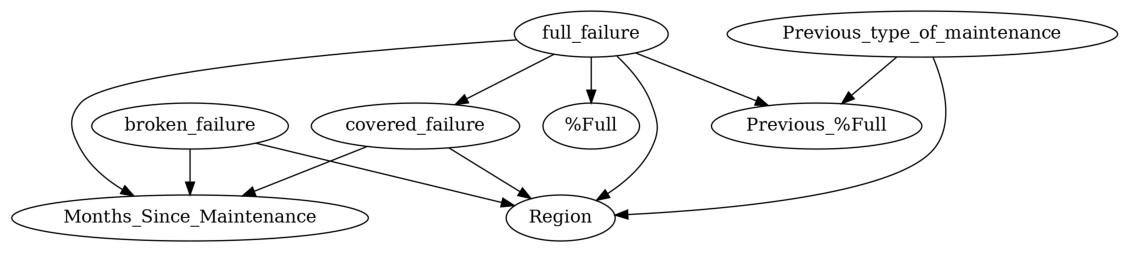

In [94]:
pyd = GraphUtils.to_pydot(LINGNAM_dag,labels=list(struct_data.columns.values))
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(img)
plt.show()

In [108]:
from castle.algorithms import ICALiNGAM

# DirectLiNGAM learn
ical_lignam = ICALiNGAM()
ical_lignam.learn(struct_data)



/home/tgraham/.local/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(
/home/tgraham/.local/lib/python3.8/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/home/tgraham/.local/lib/python3.8/site-packages/sklearn/linear_model/_b

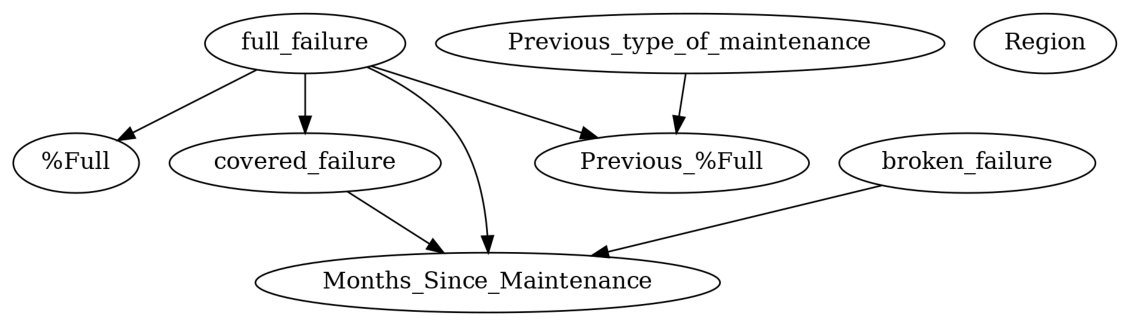

In [109]:
ICALiNGNAM_dag = create_dag_from_gcastle(ical_lignam,struct_data)
pyd = GraphUtils.to_pydot(ICALiNGNAM_dag,labels=list(struct_data.columns.values))
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(img)
plt.show()

## GOLEM

In [101]:
from castle.algorithms import GOLEM

# DirectLiNGAM learn
#golem = GOLEM()
#golem.learn(struct_data)

# Took too long

## DAG-GNN Graph Neural Network

In [102]:
from castle.algorithms import DAG_GNN


#gnn = DAG_GNN()
#gnn.learn(data=struct_data)
# Took Too long

## Convert Edges to vector

# CausalLearn Package

In [789]:
struct_data

,%Full,Region,full_failure,covered_failure,broken_failure,Previous_%Full,Previous_type_of_maintenance,Months_Since_Maintenance
15458,1,2,0,0,0,1,1,0
15460,2,2,0,0,0,2,1,0
15462,2,2,0,0,0,2,1,0
15464,2,2,0,0,0,2,1,0
15466,2,2,0,0,0,2,1,0
...,...,...,...,...,...,...,...,...
551199,4,3,0,0,0,2,1,2
551200,4,3,0,0,0,2,1,2
551201,2,1,0,0,0,3,0,2
551202,2,1,0,0,0,3,0,2


## GES

In [178]:
from causallearn.search.ScoreBased.GES import ges
score_func = "local_score_BDeu"
Record = ges(struct_data, score_func)

[[ 0  1  0  0  0  0  0  0]
 [-1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]]
[[ 0 -1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0 -1  0  0  0  0  0  0]]
[[ 0 -1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  1  1]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0 -1  0  0  0  0  0  0]
 [ 0 -1  0  0  0  0  0  0]]
[[ 0 -1  0  0  0  0  0  0]
 [ 1  0  0  0  0  1  1  1]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0 -1  0  0  0  0  0  0]
 [ 0 -1  0  0  0  0  0  0]
 [ 0 -1  0  0  0  0  0  0]]
[[ 0 -1  0  0  0  0  0  1]
 [ 1  0  0  0  0  1  1  1]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  

In [179]:
print(f"Bdeu score: {Record['score']}")

Bdeu score: 2574553.1892441297


In [180]:
struct_data

,%Full,Region,full_failure,covered_failure,broken_failure,Previous_%Full,Previous_type_of_maintenance,Months_Since_Maintenance
15458,1,2,0,0,0,1,1,0
15460,2,2,0,0,0,2,1,0
15462,2,2,0,0,0,2,1,0
15464,2,2,0,0,0,2,1,0
15466,2,2,0,0,0,2,1,0
...,...,...,...,...,...,...,...,...
551199,4,3,0,0,0,2,1,2
551200,4,3,0,0,0,2,1,2
551201,2,1,0,0,0,3,0,2
551202,2,1,0,0,0,3,0,2


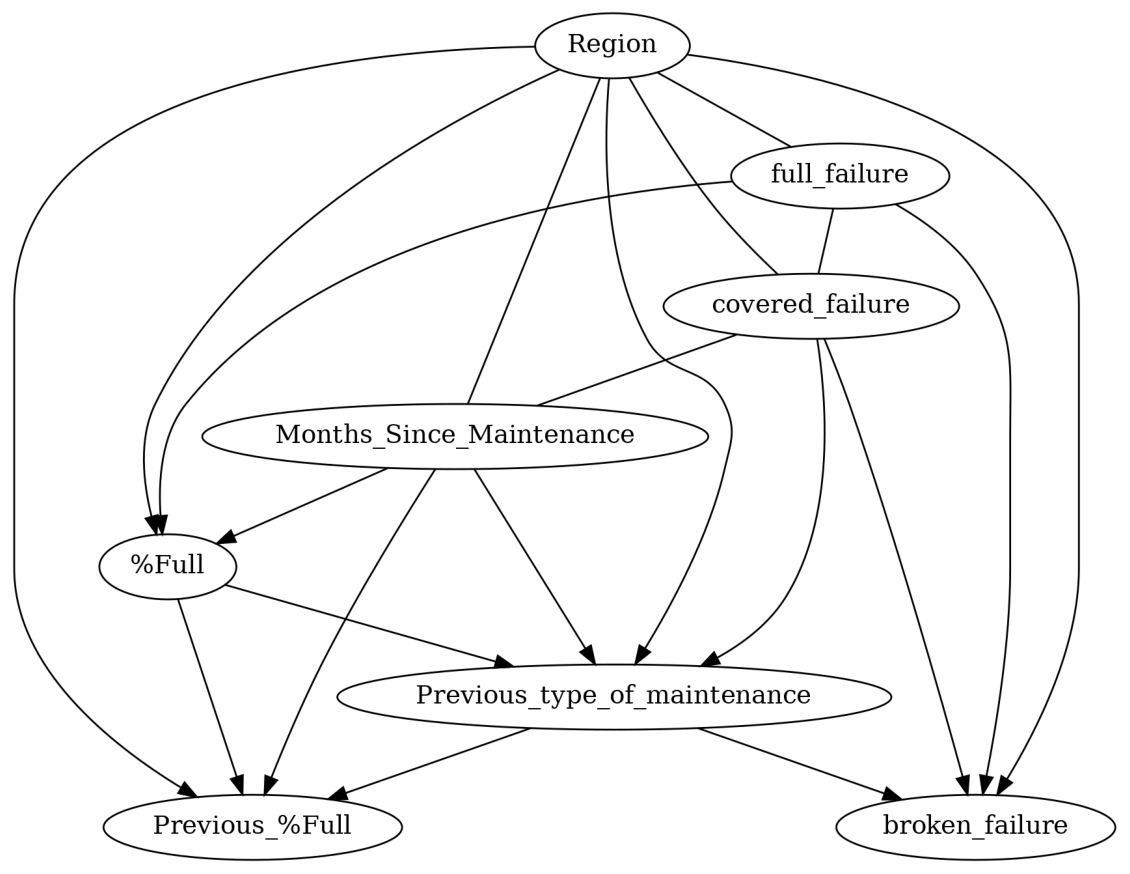

In [181]:
# Visualization using pydot
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io

pyd = GraphUtils.to_pydot(Record['G'],labels=list(struct_data.columns.values))
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(img)
plt.show()


# or save the graph
pyd.write_png('GES_algorithm.png')

## PC-Stable

In [192]:
from causallearn.search.ConstraintBased.PC import pc

In [193]:
struct_array = struct_data.to_numpy()

In [194]:
cg = pc(struct_array, alpha=0.05,stable=True, indep_test = "fisherz",verbose= False)

  0%|          | 0/8 [00:00<?, ?it/s]

In [195]:
cg.G

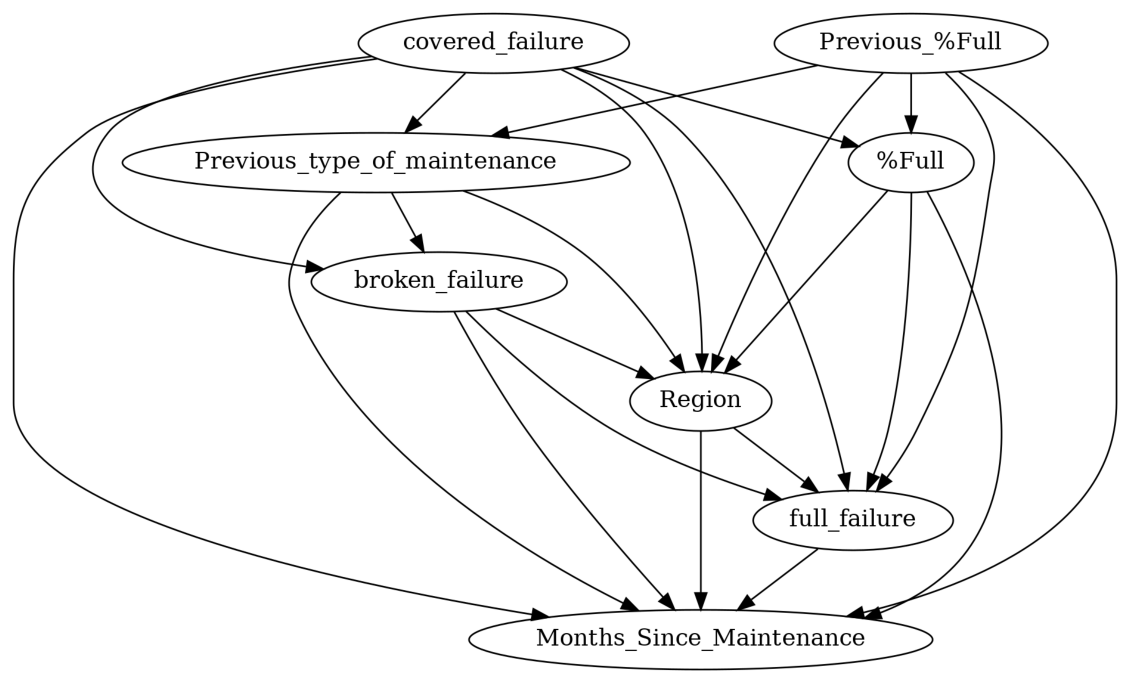

In [196]:
from matplotlib.pyplot import figure
# visualization using pydot
pyd = GraphUtils.to_pydot(cg.G,labels=list(struct_data.columns.values))
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(img)
plt.show()
pyd.write_png('PC.png')

## FCI 

In [110]:
from causallearn.search.ConstraintBased.FCI import fci

In [171]:
struct_array = struct_data.to_numpy()

In [172]:
cg_fci, edges = fci(struct_array, alpha=0.05, indep_test = "fisherz",verbose= False)

  0%|          | 0/8 [00:00<?, ?it/s]

X2 --> X3
X4 --> X3
X3 --> X5
X4 --> X5
X7 --> X5


In [173]:
edges[0].get_numerical_endpoint1(),edges[0].get_numerical_endpoint2(),

(1, 1)

In [174]:
struct_data.columns

Index(['%Full', 'Region', 'full_failure', 'covered_failure', 'broken_failure',
       'Previous_%Full', 'Previous_type_of_maintenance',
       'Months_Since_Maintenance'],
      dtype='object')

# Continue here to start building the comparison metric - I can build this out of the logic included in the covid paper

In [211]:
edges = truth_dag.get_graph_edges()

In [218]:
broken_down_edges = []
for edge in edges:
    broken_down_edges.append([(edge.get_node1().name,edge.get_numerical_endpoint1()),(edge.get_node2().name,edge.get_numerical_endpoint2())])

In [239]:
mapping = {}
for i, c in enumerate(struct_data.columns):
    mapping[c] = i

In [240]:
mapping

{'%Full': 0,
 'Region': 1,
 'full_failure': 2,
 'covered_failure': 3,
 'broken_failure': 4,
 'Previous_%Full': 5,
 'Previous_type_of_maintenance': 6,
 'Months_Since_Maintenance': 7}

In [321]:
broken_down_edges

[[('Region', -1), ('%Full', 1)],
 [('%Full', -1), ('full_failure', 1)],
 [('%Full', -1), ('covered_failure', 1)],
 [('Previous_%Full', -1), ('%Full', 1)],
 [('Previous_type_of_maintenance', -1), ('%Full', 1)],
 [('Months_Since_Maintenance', -1), ('%Full', 1)],
 [('Region', -1), ('full_failure', 1)],
 [('Region', -1), ('covered_failure', 1)],
 [('Region', -1), ('broken_failure', 1)],
 [('Region', -1), ('Previous_%Full', 1)],
 [('Region', -1), ('Previous_type_of_maintenance', 1)],
 [('Region', -1), ('Months_Since_Maintenance', 1)],
 [('Previous_%Full', -1), ('full_failure', 1)],
 [('Previous_type_of_maintenance', -1), ('full_failure', 1)],
 [('Months_Since_Maintenance', -1), ('full_failure', 1)],
 [('covered_failure', -1), ('broken_failure', 1)],
 [('Previous_type_of_maintenance', -1), ('covered_failure', 1)],
 [('Months_Since_Maintenance', -1), ('covered_failure', 1)],
 [('Months_Since_Maintenance', -1), ('broken_failure', 1)],
 [('Previous_type_of_maintenance', -1), ('Previous_%Full', 

In [334]:
matrix = len(struct_data.columns)*[len(struct_data.columns)*[0]]

In [335]:
positions = [[0 for j in range(len(struct_data.columns))] for i in range(len(struct_data.columns))]
positions

[[0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0]]

In [338]:
for index, column in enumerate(struct_data.columns):
    # find all outband edges 
    for item in broken_down_edges:
        if item[0][0] == column:
            y = mapping[item[0][0]]
            x = mapping[item[1][0]]
            #print(y,x)
            positions[y][x] = item[1][1]
            #print(item[0][1],item[1][1])
            #print(mapping[item[0][0]],mapping[item[1][0]])
    # find all inbound edges
    #print("inbound")
    for item in broken_down_edges:
        if item[1][0] == column:
            y = mapping[item[0][0]]
            x = mapping[item[1][0]]
            #print(item)
            positions[x][y] = item[0][1]

In [339]:
positions

[[0, -1, 1, 1, 0, -1, -1, -1],
 [1, 0, 1, 1, 1, 1, 1, 1],
 [-1, -1, 0, 0, 0, -1, -1, -1],
 [-1, -1, 0, 0, 1, 0, -1, -1],
 [0, -1, 0, -1, 0, 0, 0, -1],
 [1, -1, 1, 0, 0, 0, -1, 1],
 [1, -1, 1, 1, 0, 1, 0, 1],
 [1, -1, 1, 1, 1, -1, -1, 0]]

In [345]:
m = np.asarray(positions)
m

array([[ 0, -1,  1,  1,  0, -1, -1, -1],
       [ 1,  0,  1,  1,  1,  1,  1,  1],
       [-1, -1,  0,  0,  0, -1, -1, -1],
       [-1, -1,  0,  0,  1,  0, -1, -1],
       [ 0, -1,  0, -1,  0,  0,  0, -1],
       [ 1, -1,  1,  0,  0,  0, -1,  1],
       [ 1, -1,  1,  1,  0,  1,  0,  1],
       [ 1, -1,  1,  1,  1, -1, -1,  0]])

In [346]:

dag = create_dag_from_gcastle(m,struct_data)
pyd = GraphUtils.to_pydot(dag,labels=list(struct_data.columns.values))
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(img)
plt.show()

UnboundLocalError: local variable 'learned_graph' referenced before assignment

In [ ]:
for item in 

In [134]:
[edges[0].get_node1().name,edges[0].get_node2().name]

['X1', 'X2']

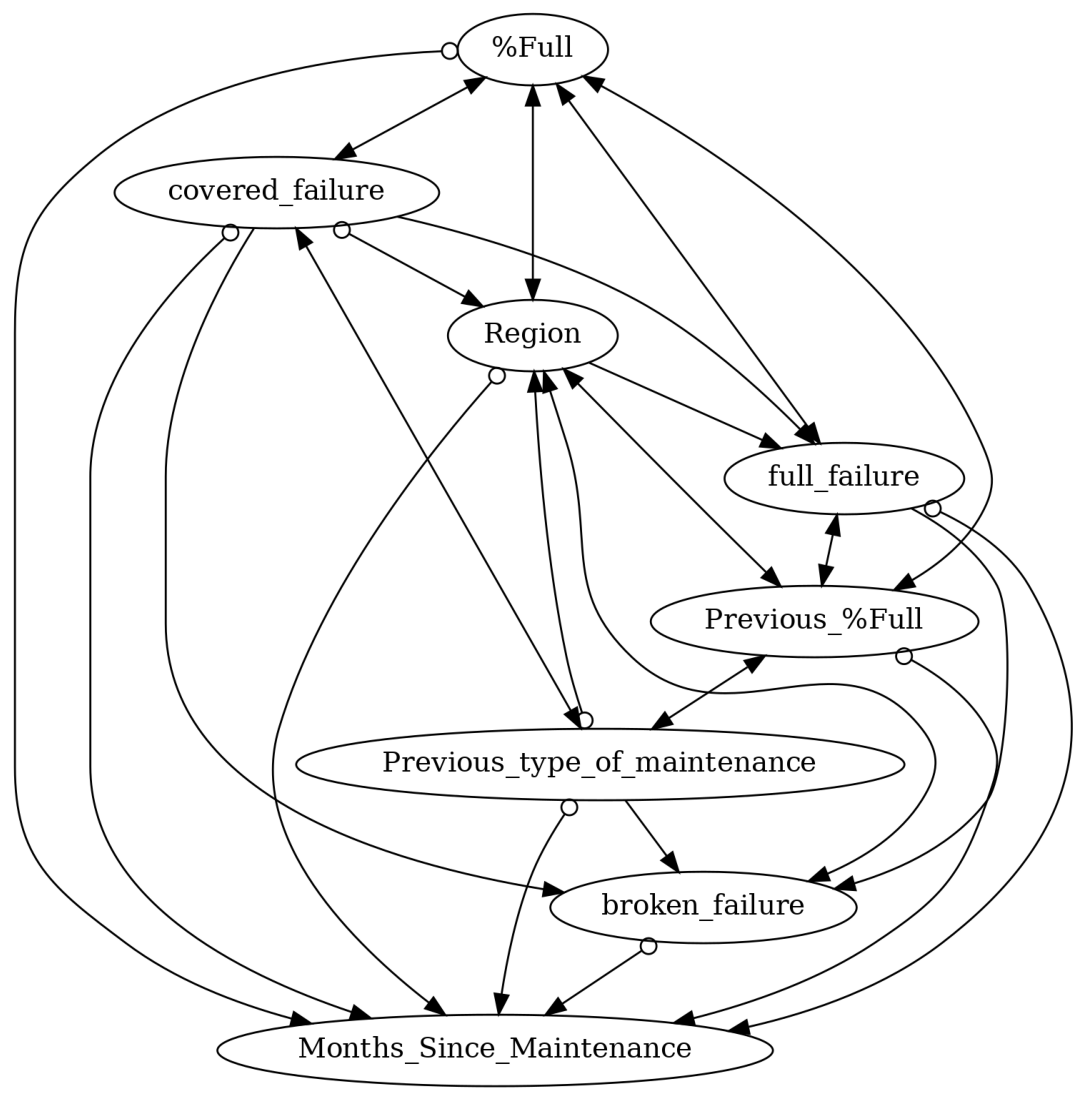

In [113]:
pyd = GraphUtils.to_pydot(cg_fci,labels=list(struct_data.columns.values))
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(img)
plt.show()

pyd.write_png('FCI.png')

In [143]:
from causallearn.search.PermutationBased.GRaSP import grasp
score_func="local_score_BDeu"
# or customized parameters
G = grasp(struct_array, score_func)

GRaSP edge count: 21    
GRaSP completed in: 70.12s 


In [151]:
grasp_edges = G.get_graph_edges()

In [152]:
for edge in grasp_edges:
    print([edge.get_node1().name,edge.get_numerical_endpoint1(),edge.get_node2().name,edge.get_numerical_endpoint2()])

['x0', -1, 'x1', -1]
['x0', -1, 'x2', -1]
['x0', -1, 'x5', -1]
['x0', -1, 'x6', -1]
['x0', -1, 'x7', -1]
['x1', -1, 'x2', -1]
['x1', -1, 'x3', 1]
['x1', -1, 'x4', 1]
['x1', -1, 'x5', -1]
['x1', -1, 'x6', -1]
['x1', -1, 'x7', -1]
['x2', -1, 'x3', 1]
['x2', -1, 'x4', 1]
['x2', -1, 'x7', -1]
['x3', -1, 'x4', 1]
['x6', -1, 'x3', 1]
['x7', -1, 'x3', 1]
['x6', -1, 'x4', 1]
['x5', -1, 'x6', -1]
['x5', -1, 'x7', -1]
['x6', -1, 'x7', -1]


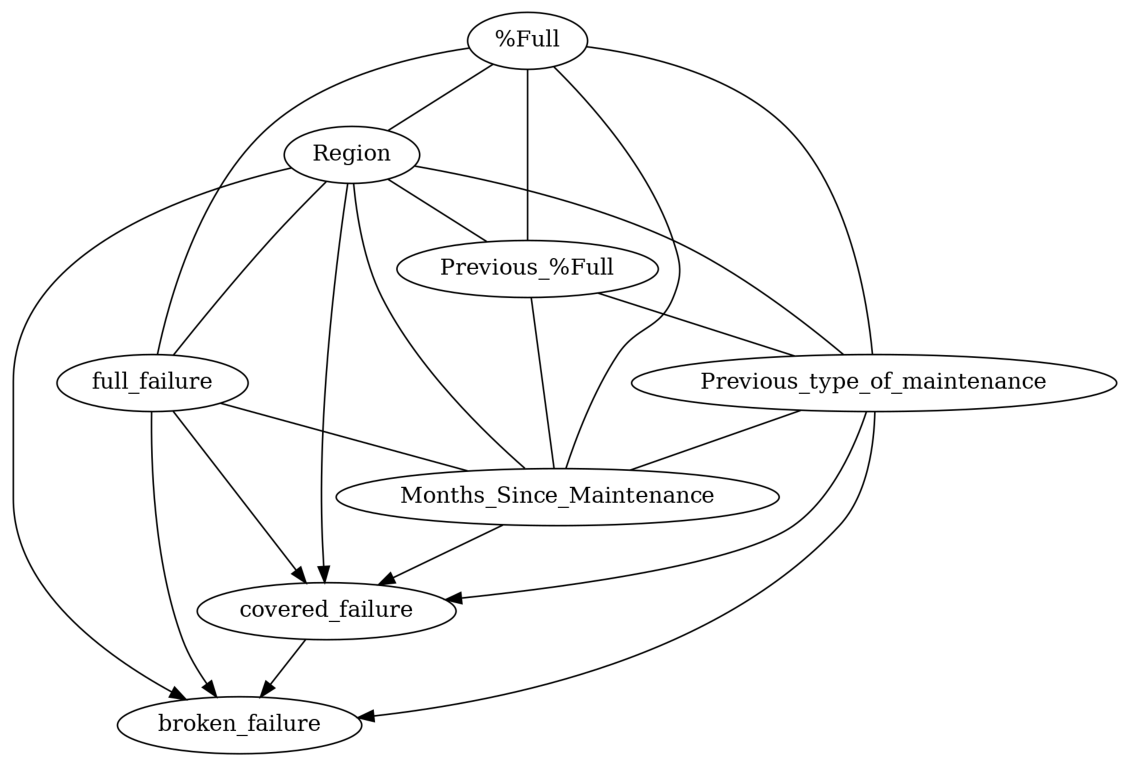

In [145]:
pyd = GraphUtils.to_pydot(G,labels=list(struct_data.columns.values))
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(img)
plt.show()
pyd.write_png('GRASP.png')

# Bnlearn

## HillClimbSearch

In [808]:
# Load library
import bnlearn as bn
# Load example
df = bn.import_example('sprinkler')
# Structure learning
model = bn.structure_learning.fit(struct_data, methodtype='hc', scoretype='bdeu')
# Compute edge strength using chi-square independence test and remove (prune) the not-signficant edges
model1 = bn.independence_test(model, struct_data, alpha=0.05, prune=False)
# Examine the output of the chi-square test. All P values are significant. Nothing is removed.
#    source     target     stat_test        p_value    chi_square    dof
#--  ---------  ---------  -----------  -----------  ------------  -----
# 0  Cloudy     Rain       True         1.08061e-87       394.062      1
# 1  Cloudy     Sprinkler  True         8.38371e-53       233.906      1
# 2  Rain       Wet_Grass  True         3.88651e-64       285.902      1
# 3  Sprinkler  Wet_Grass  True         1.19692e-23       100.478      1

# Plot
# Compute edge strength using chi-square independence test and remove (prune) the not-signficant edges
model3 = bn.independence_test(model, struct_data, alpha=0.05, prune=True)

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bdeu]
[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Compute edge strength with [chi_square]
[bnlearn] >Compute edge strength with [chi_square]


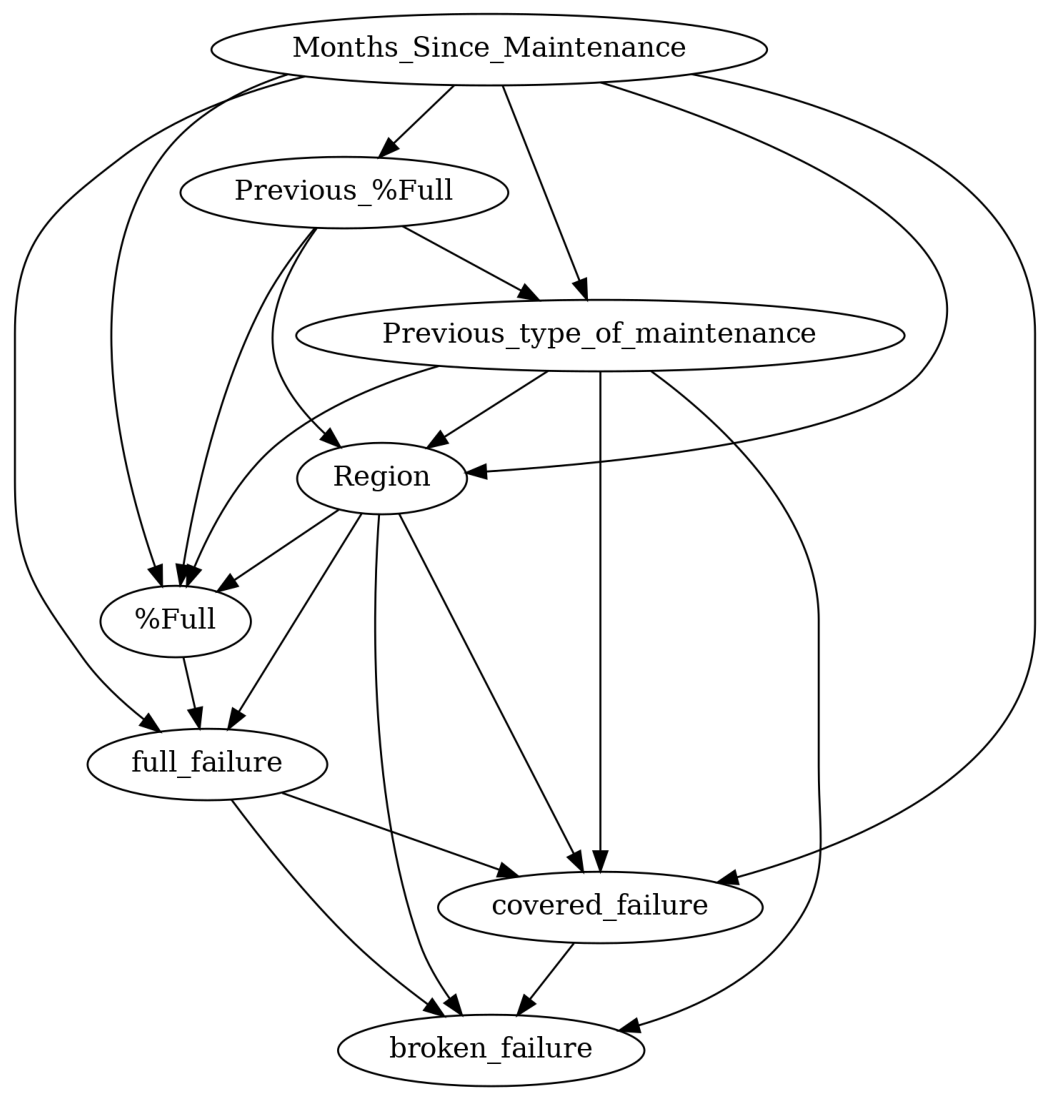

In [809]:
node_names = struct_data.columns
nodes = []
for name in node_names:
    node = GraphNode(name)
    nodes.append(node)
dag = Dag(nodes)

for item in model3["model_edges"]:
    node1 = dag.get_node(item[0])
    node2 = dag.get_node(item[1])
    dag.add_directed_edge(node1, node2)
# visualization using pydot
pyd = GraphUtils.to_pydot(dag,labels=list(struct_data.columns.values))
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(img)
plt.show()

pyd.write_png('HillClimb.png')

# Use Background Knowledge

### GCastle Background Knowledge code

In [81]:
#priori = PrioriKnowledge(struct_data.shape[1])
#priori.add_forbidden_edges(output)
#pc = PC(variant='stable',priori_knowledge=priori,alpha=0.8)

In [810]:
mapped = {}
for index, item in enumerate(struct_data.columns):
    mapped[item]=index
forbidden_edges = [("%Full", "Previous_%Full"),
                    ("Months_Since_Maintenance","Previous_%Full"),
                    ("%Full","Region"),
                    ("Previous_%Full", "Region"),
                    ("broken_failure","Region"),
                    ("covered_failure","Region"),
                    ("full_failure","Region"),
                    ("full_failure","Months_Since_Maintenance"),
                    ("covered_failure","Months_Since_Maintenance"),
                    ("broken_failure","Months_Since_Maintenance"),
                    ("full_failure","Previous_%Full"),
                    ("covered_failure","Previous_%Full"),
                    ("broken_failure","Previous_%Full"),
                    ("full_failure","Previous_type_of_maintenance"),
                    ("covered_failure","Previous_type_of_maintenance"),
                    ("broken_failure","Previous_type_of_maintenance")]
output = []
for item in forbidden_edges:
    output.append((mapped[item[0]],mapped[item[1]]))

In [811]:
from causallearn.utils.PCUtils.BackgroundKnowledge import BackgroundKnowledge
from causallearn.graph.GraphClass import CausalGraph
cg = CausalGraph(8)
nodes = cg.G.get_nodes()

In [812]:
bk = BackgroundKnowledge()
for item in output:
    bk.add_forbidden_by_node(nodes[item[0]], nodes[item[1]])

In [813]:
struct_array = struct_data.to_numpy()

## PC - Background knowledge

In [814]:
cg_pc = pc(struct_array, alpha=0.05, indep_test = "fisherz",verbose= False, background_knowledge=bk)

  0%|          | 0/8 [00:00<?, ?it/s]

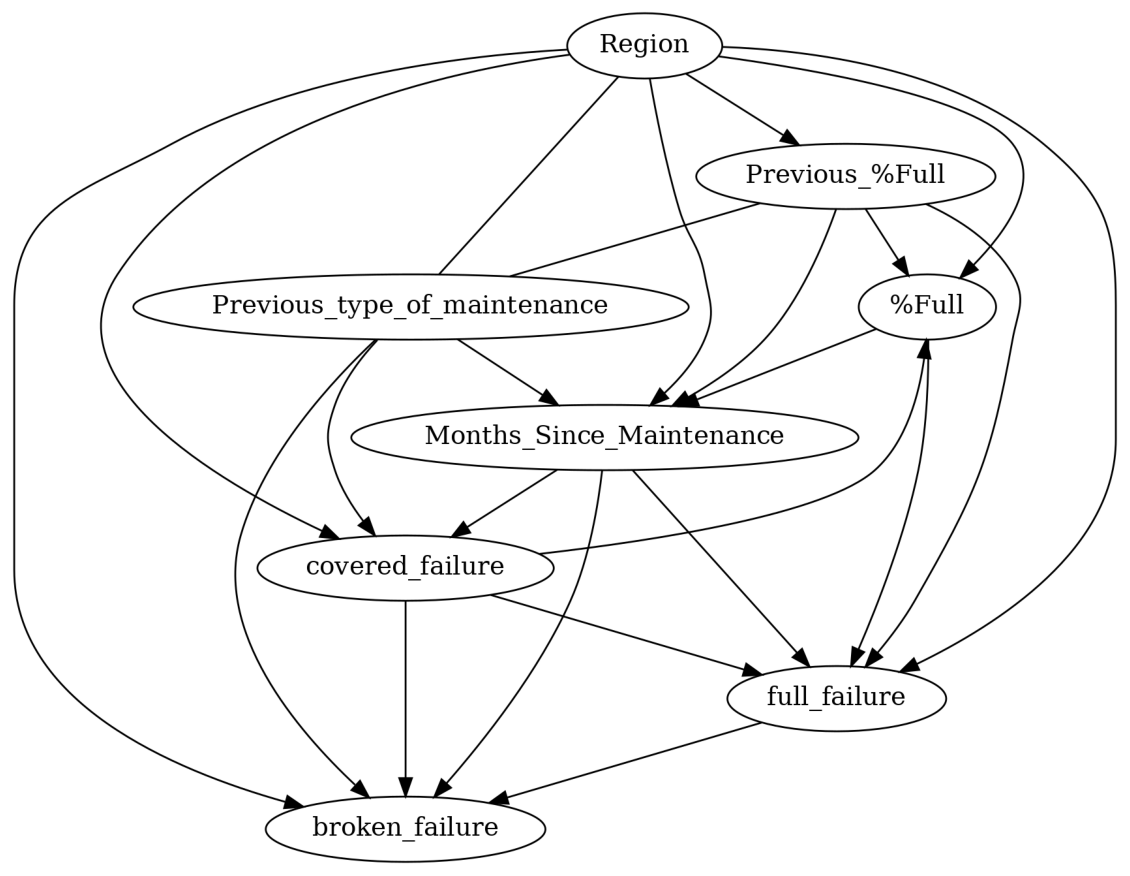

In [815]:
# visualization using pydot
pyd = GraphUtils.to_pydot(cg_pc.G,labels=list(struct_data.columns.values))
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(img)
plt.show()


pyd.write_png('PC_Background_Knowledge.png')

## FCI - Background Knowledge

In [816]:
cg_fci, edges = fci(struct_array, alpha=0.05, indep_test = "fisherz",verbose= False,background_knowledge=bk)

  0%|          | 0/8 [00:00<?, ?it/s]

Starting BK Orientation.
Orienting edge (Knowledge): X2 --> X1
Orienting edge (Knowledge): X6 --> X1
Orienting edge (Knowledge): X2 --> X3
Orienting edge (Knowledge): X2 --> X4
Orienting edge (Knowledge): X2 --> X5
Orienting edge (Knowledge): X2 --> X6
Orienting edge (Knowledge): X6 --> X3
Orienting edge (Knowledge): X8 --> X3
Orienting edge (Knowledge): X7 --> X4
Orienting edge (Knowledge): X8 --> X4
Orienting edge (Knowledge): X7 --> X5
Orienting edge (Knowledge): X8 --> X5
Orienting edge (Knowledge): X6 --> X8
Finishing BK Orientation.
Starting BK Orientation.
Orienting edge (Knowledge): X2 --> X1
Orienting edge (Knowledge): X6 --> X1
Orienting edge (Knowledge): X2 --> X3
Orienting edge (Knowledge): X2 --> X4
Orienting edge (Knowledge): X2 --> X5
Orienting edge (Knowledge): X2 --> X6
Orienting edge (Knowledge): X6 --> X3
Orienting edge (Knowledge): X8 --> X3
Orienting edge (Knowledge): X7 --> X4
Orienting edge (Knowledge): X8 --> X4
Orienting edge (Knowledge): X7 --> X5
Orienting ed

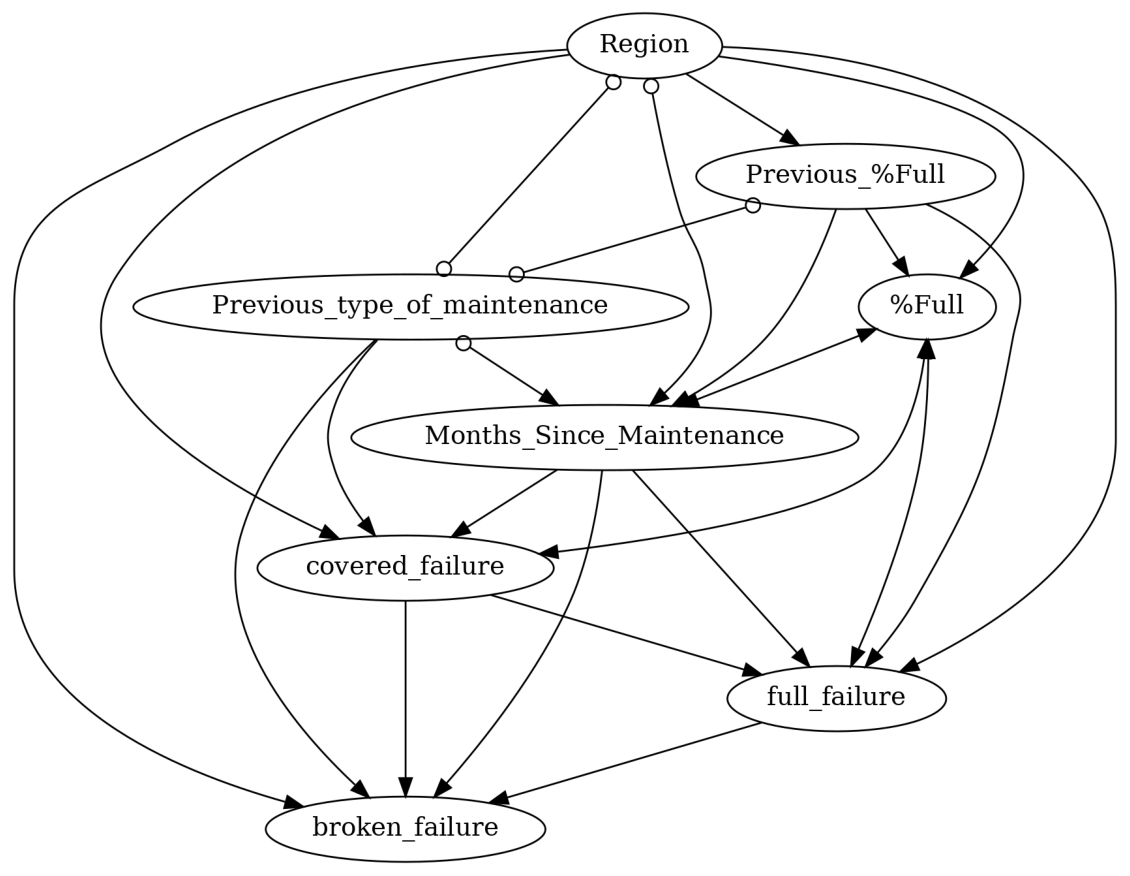

In [817]:
# visualization using pydot
pyd = GraphUtils.to_pydot(cg_fci,labels=list(struct_data.columns.values))
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(img)
plt.show()


pyd.write_png('simple_test.png')

In [631]:
print(cg_fci)

Graph Nodes:
X1;X2;X3;X4;X5;X6;X7;X8

Graph Edges:
1. X2 --> X1
2. X1 <-> X3
3. X1 <-> X4
4. X6 --> X1
5. X1 <-> X8
6. X2 --> X3
7. X2 --> X4
8. X2 --> X5
9. X2 --> X6
10. X2 o-o X7
11. X2 o-> X8
12. X4 --> X3
13. X3 --> X5
14. X6 --> X3
15. X8 --> X3
16. X4 --> X5
17. X7 --> X4
18. X8 --> X4
19. X7 --> X5
20. X8 --> X5
21. X6 o-o X7
22. X6 --> X8
23. X7 o-> X8



In [632]:
edges = []
for edge in cg_fci.get_graph_edges():
    edges.append((edge.get_node1().get_name(),edge.get_node2().get_name()))

In [633]:
edges

[('X2', 'X1'),
 ('X1', 'X3'),
 ('X1', 'X4'),
 ('X6', 'X1'),
 ('X1', 'X8'),
 ('X2', 'X3'),
 ('X2', 'X4'),
 ('X2', 'X5'),
 ('X2', 'X6'),
 ('X2', 'X7'),
 ('X2', 'X8'),
 ('X4', 'X3'),
 ('X3', 'X5'),
 ('X6', 'X3'),
 ('X8', 'X3'),
 ('X4', 'X5'),
 ('X7', 'X4'),
 ('X8', 'X4'),
 ('X7', 'X5'),
 ('X8', 'X5'),
 ('X6', 'X7'),
 ('X6', 'X8'),
 ('X7', 'X8')]

In [819]:
1200, 1220
list(range(1200,1220+1))

[1200,
 1201,
 1202,
 1203,
 1204,
 1205,
 1206,
 1207,
 1208,
 1209,
 1210,
 1211,
 1212,
 1213,
 1214,
 1215,
 1216,
 1217,
 1218,
 1219,
 1220]

# Learn Parameters

### bnlearn

In [430]:
dag.get_nodes()

In [435]:
print(dag.get_causal_ordering())

[<causallearn.graph.GraphNode.GraphNode object at 0x7fa6a67018e0>, <causallearn.graph.GraphNode.GraphNode object at 0x7fa75cf1c8e0>, <causallearn.graph.GraphNode.GraphNode object at 0x7fa75cf1c970>, <causallearn.graph.GraphNode.GraphNode object at 0x7fa75cf1c370>, <causallearn.graph.GraphNode.GraphNode object at 0x7fa75cf1c580>, <causallearn.graph.GraphNode.GraphNode object at 0x7fa75cf1cf10>, <causallearn.graph.GraphNode.GraphNode object at 0x7fa75cf1c3a0>, <causallearn.graph.GraphNode.GraphNode object at 0x7fa75cf1ce80>, <causallearn.graph.GraphNode.GraphNode object at 0x7fa75cc96310>]


### causallearn

In [655]:
print(dag)

Graph Nodes:
%Full;Region;full_failure;covered_failure;broken_failure;Previous_%Full;Previous_type_of_maintenance;Months_Since_Maintenance

Graph Edges:
1. Region --> %Full
2. %Full --> full_failure
3. %Full --> covered_failure
4. Previous_%Full --> %Full
5. Previous_type_of_maintenance --> %Full
6. Months_Since_Maintenance --> %Full
7. Region --> full_failure
8. Region --> covered_failure
9. Region --> broken_failure
10. Region --> Previous_%Full
11. Region --> Previous_type_of_maintenance
12. Region --> Months_Since_Maintenance
13. Previous_%Full --> full_failure
14. Previous_type_of_maintenance --> full_failure
15. Months_Since_Maintenance --> full_failure
16. covered_failure --> broken_failure
17. Previous_type_of_maintenance --> covered_failure
18. Months_Since_Maintenance --> covered_failure
19. Months_Since_Maintenance --> broken_failure
20. Previous_type_of_maintenance --> Previous_%Full
21. Previous_%Full --> Months_Since_Maintenance
22. Previous_type_of_maintenance --> Months

In [656]:
# The below code extracts the edges from a dag so that a bnlearn dag structure can be  created
edges = []
for edge in dag.get_graph_edges():
    edges.append((edge.get_node1().get_name(),edge.get_node2().get_name()))

In [657]:
print(dag.get_node_map())

{<causallearn.graph.GraphNode.GraphNode object at 0x7fa6978167c0>: 0, <causallearn.graph.GraphNode.GraphNode object at 0x7fa697816850>: 1, <causallearn.graph.GraphNode.GraphNode object at 0x7fa697816970>: 2, <causallearn.graph.GraphNode.GraphNode object at 0x7fa697816af0>: 3, <causallearn.graph.GraphNode.GraphNode object at 0x7fa697816ca0>: 4, <causallearn.graph.GraphNode.GraphNode object at 0x7fa697816c10>: 5, <causallearn.graph.GraphNode.GraphNode object at 0x7fa697816d60>: 6, <causallearn.graph.GraphNode.GraphNode object at 0x7fa6978165e0>: 7}


[bnlearn] >bayes DAG created.
[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


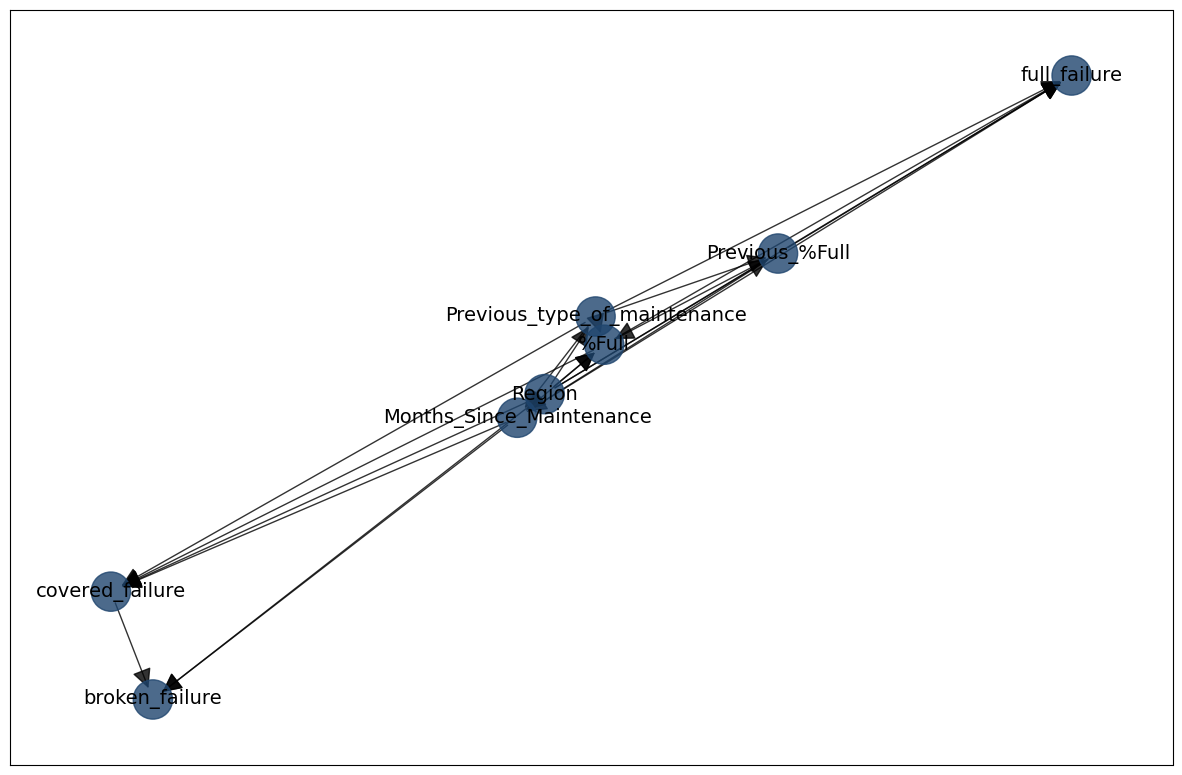

[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >CPD of Region:
+-----------+-------------+
| Region(1) | 0.341443    |
+-----------+-------------+
| Region(2) | 0.292376    |
+-----------+-------------+
| Region(3) | 0.182389    |
+-----------+-------------+
| Region(4) | 0.115582    |
+-----------+-------------+
| Region(5) | 0.0594986   |
+-----------+-------------+
| Region(6) | 0.00541467  |
+-----------+-------------+
| Region(7) | 0.00256726  |
+-----------+-------------+
| Region(8) | 0.000729363 |
+-----------+-------------+
[bnlearn] >CPD of %Full:
+------------------------------+-----+---------------------------------+
| Months_Since_Maintenance     | ... | Months_Since_Maintenance(8)     |
+------------------------------+-----+---------------------------------+
| Previous_%Full               | ... | Previous_%Full(4)               |
+------------------------------+-----+---------------------------------+
| Previous_type_of_maintenance | ... | Pre

In [658]:
#edges = [('A', 'B'), ('A', 'C'), ('A', 'D')]
# Create DAG and store in model
model = bn.make_DAG(edges)
bn.plot(model)
DAG_update = bn.parameter_learning.fit(model, struct_data)

In [483]:
q2 = bn.inference.fit(DAG_update, variables=['full_failure','covered_failure'], evidence={"Months_Since_Maintenance":7,"Previous_%Full":4,"Previous_type_of_maintenance":1})

[bnlearn] >Variable Elimination..


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

[bnlearn] >Data is stored in [query.df]
+----+----------------+-------------------+----------+
|    |   full_failure |   covered_failure |        p |
+====+================+===================+==========+
|  0 |              0 |                 0 | 0.50282  |
+----+----------------+-------------------+----------+
|  1 |              0 |                 1 | 0.240952 |
+----+----------------+-------------------+----------+
|  2 |              1 |                 0 | 0.128114 |
+----+----------------+-------------------+----------+
|  3 |              1 |                 1 | 0.128114 |
+----+----------------+-------------------+----------+


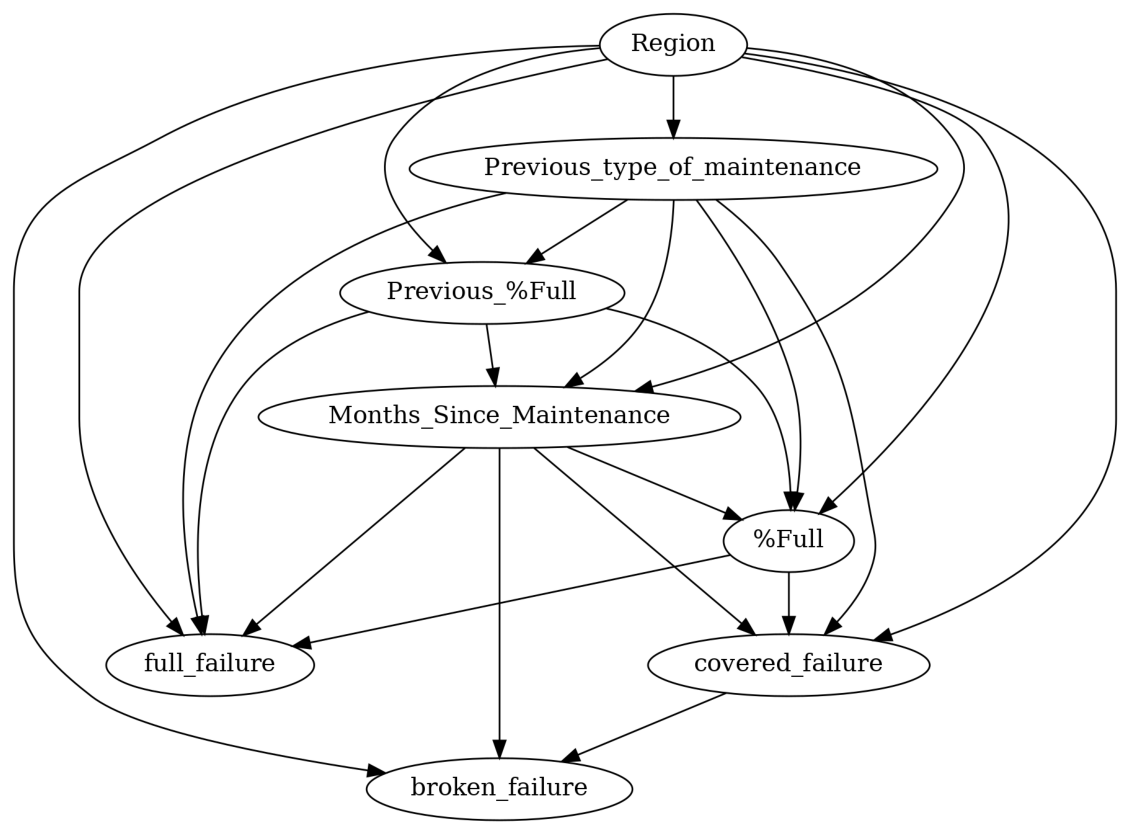

In [661]:
# visualization using pydot
pyd = GraphUtils.to_pydot(dag,labels=list(struct_data.columns.values))
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(img)
plt.show()

pyd.write_png('HillClimb.png')

## Bayesian Network with PC - Background Knowledge 

In [716]:
mapped = {}
for index, item in enumerate(struct_data.columns):
    mapped[item]=index
forbidden_edges = [("%Full", "Previous_%Full"),
                    ("Months_Since_Maintenance","Previous_%Full"),
                    ("%Full","Region"),
                    ("Previous_%Full", "Region"),
                    ("broken_failure","Region"),
                    ("covered_failure","Region"),
                    ("full_failure","Region"),
                    ("full_failure","Months_Since_Maintenance"),
                    ("covered_failure","Months_Since_Maintenance"),
                    ("broken_failure","Months_Since_Maintenance"),
                    ("full_failure","Previous_%Full"),
                    ("covered_failure","Previous_%Full"),
                    ("broken_failure","Previous_%Full"),
                    ("full_failure","Previous_type_of_maintenance"),
                    ("covered_failure","Previous_type_of_maintenance"),
                    ("broken_failure","Previous_type_of_maintenance")]
output = []
for item in forbidden_edges:
    output.append((mapped[item[0]],mapped[item[1]]))

In [717]:
bk = BackgroundKnowledge()
for item in output:
    bk.add_forbidden_by_node(nodes[item[0]], nodes[item[1]])

In [718]:
struct_array = struct_data.to_numpy()

In [722]:
struct_data

,%Full,Region,full_failure,covered_failure,broken_failure,Previous_%Full,Previous_type_of_maintenance,Months_Since_Maintenance
15458,1,2,0,0,0,1,1,0
15460,2,2,0,0,0,2,1,0
15462,2,2,0,0,0,2,1,0
15464,2,2,0,0,0,2,1,0
15466,2,2,0,0,0,2,1,0
...,...,...,...,...,...,...,...,...
551199,4,3,0,0,0,2,1,2
551200,4,3,0,0,0,2,1,2
551201,2,1,0,0,0,3,0,2
551202,2,1,0,0,0,3,0,2


In [724]:
cg_pc = pc(struct_array, alpha=0.05, indep_test = "fisherz",verbose= False, background_knowledge=bk)

  0%|          | 0/8 [00:00<?, ?it/s]

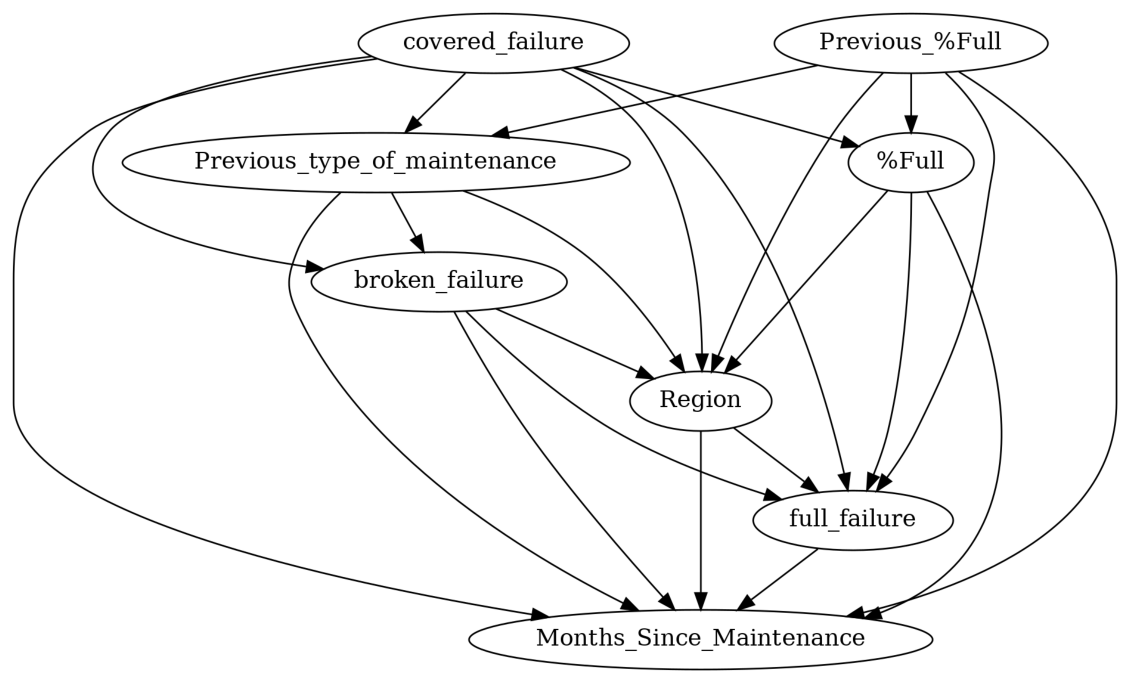

In [725]:
# visualization using pydot
pyd = GraphUtils.to_pydot(cg_pc.G,labels=list(struct_data.columns.values))
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(img)
plt.show()

pyd.write_png('PC_Backgroun.png')

In [671]:
print(cg_pc.G)

Graph Nodes:
X1;X2;X3;X4;X5;X6;X7;X8

Graph Edges:
1. X1 --> X2
2. X1 --> X3
3. X4 --> X1
4. X6 --> X1
5. X1 --> X8
6. X2 --> X3
7. X4 --> X2
8. X5 --> X2
9. X6 --> X2
10. X7 --> X2
11. X2 --> X8
12. X4 --> X3
13. X5 --> X3
14. X6 --> X3
15. X3 --> X8
16. X4 --> X5
17. X4 --> X7
18. X4 --> X8
19. X7 --> X5
20. X5 --> X8
21. X6 --> X7
22. X6 --> X8
23. X7 --> X8



In [667]:
edges = []
for edge in cg_pc.G.get_graph_edges():
    edges.append((edge.get_node1().get_name(),edge.get_node2().get_name()))

In [669]:
edges

[('X2', 'X1'),
 ('X1', 'X3'),
 ('X4', 'X1'),
 ('X6', 'X1'),
 ('X1', 'X8'),
 ('X2', 'X3'),
 ('X2', 'X4'),
 ('X2', 'X5'),
 ('X2', 'X6'),
 ('X2', 'X7'),
 ('X2', 'X8'),
 ('X4', 'X3'),
 ('X3', 'X5'),
 ('X6', 'X3'),
 ('X8', 'X3'),
 ('X4', 'X5'),
 ('X7', 'X4'),
 ('X8', 'X4'),
 ('X7', 'X5'),
 ('X8', 'X5'),
 ('X6', 'X7'),
 ('X6', 'X8'),
 ('X7', 'X8')]

In [701]:
struct_data

,%Full,Region,full_failure,covered_failure,broken_failure,Previous_%Full,Previous_type_of_maintenance,Months_Since_Maintenance
15458,1,2,0,0,0,1,1,0
15460,2,2,0,0,0,2,1,0
15462,2,2,0,0,0,2,1,0
15464,2,2,0,0,0,2,1,0
15466,2,2,0,0,0,2,1,0
...,...,...,...,...,...,...,...,...
551199,4,3,0,0,0,2,1,2
551200,4,3,0,0,0,2,1,2
551201,2,1,0,0,0,3,0,2
551202,2,1,0,0,0,3,0,2


In [691]:
mapped = {}
for item in range(1,9):
    mapped[f"X{item}"]=item

In [692]:
struct_array.shape

(413060, 8)

In [693]:
mapped

{'X1': 1, 'X2': 2, 'X3': 3, 'X4': 4, 'X5': 5, 'X6': 6, 'X7': 7, 'X8': 8}

In [700]:
for item in mapped:
    print(item,item[1])

X1 1
X2 2
X3 3
X4 4
X5 5
X6 6
X7 7
X8 8


In [668]:
# Create DAG and store in model
model = bn.make_DAG(edges)
bn.plot(model)
DAG_update = bn.parameter_learning.fit(model, struct_data)

[bnlearn] >bayes DAG created.


NetworkXError: Input is not a valid edge list

In [ ]:
# visualization using pydot
pyd = GraphUtils.to_pydot(dag,labels=list(struct_data.columns.values))
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(img)
plt.show()

pyd.write_png('HillClimb.png')

# Create a manually classified causal graph

In [154]:
from causallearn.utils.PCUtils.BackgroundKnowledge import BackgroundKnowledge
from causallearn.graph.GraphClass import CausalGraph
from causallearn.utils.PCUtils.BackgroundKnowledgeOrientUtils import orient_by_background_knowledge
cg = CausalGraph(9)
nodes = cg.G.get_nodes()

In [155]:
struct_data.columns

Index(['%Full', 'Region', 'full_failure', 'covered_failure', 'broken_failure',
       'Previous_%Full', 'Previous_type_of_maintenance',
       'Months_Since_Maintenance'],
      dtype='object')

In [159]:
from causallearn.graph.Dag import Dag
from causallearn.graph.Edge import Edge
from causallearn.graph.Endpoint import Endpoint
from causallearn.graph.GraphNode import GraphNode

mapped = {}
for index, item in enumerate(struct_data.columns):
    mapped[item]=index
required_edges = [("Region","Months_Since_Maintenance"),
                  ("Region","full_failure"),
                  ("Region","covered_failure"),
                  ("Region","Previous_%Full"),
                  ("Region","broken_failure"),
                  ("Region","%Full"),
                  ("Region","Previous_type_of_maintenance"),
                  ("Months_Since_Maintenance","full_failure"),
                  ("Months_Since_Maintenance","covered_failure"),
                  ("Months_Since_Maintenance","broken_failure"),
                  ("Months_Since_Maintenance","%Full"),
                  ("Previous_%Full","%Full"),
                  ("Previous_%Full","full_failure"),
                  ("Previous_%Full","Months_Since_Maintenance"),
                  ("%Full","full_failure"),
                  ("%Full","covered_failure"),
                  ("Previous_type_of_maintenance","Previous_%Full"),
                  ("Previous_type_of_maintenance","full_failure"),
                  ("Previous_type_of_maintenance","covered_failure"),
                  ("Previous_type_of_maintenance","%Full"),
                  ("Previous_type_of_maintenance","Months_Since_Maintenance"),
                  ("covered_failure","broken_failure")]
output = []
for item in required_edges:
    output.append((mapped[item[0]],mapped[item[1]]))
    
    
node_names = struct_data.columns
nodes = []
for name in node_names:
    node = GraphNode(name)
    nodes.append(node)
dag = Dag(nodes)

for item in required_edges:
    node1 = dag.get_node(item[0])
    node2 = dag.get_node(item[1])
    dag.add_directed_edge(node1, node2)

In [160]:
#bk = BackgroundKnowledge()
#for item in output:
#    bk.add_forbidden_by_node(nodes[item[0]], nodes[item[1]])
#orient_by_background_knowledge(cg, bk)

In [162]:
node_names = struct_data.columns
nodes = []
for name in node_names:
    node = GraphNode(name)
    nodes.append(node)
dag = Dag(nodes)

for item in required_edges:
    node1 = dag.get_node(item[0])
    node2 = dag.get_node(item[1])
    dag.add_directed_edge(node1, node2)

In [184]:
truth_dag = dag

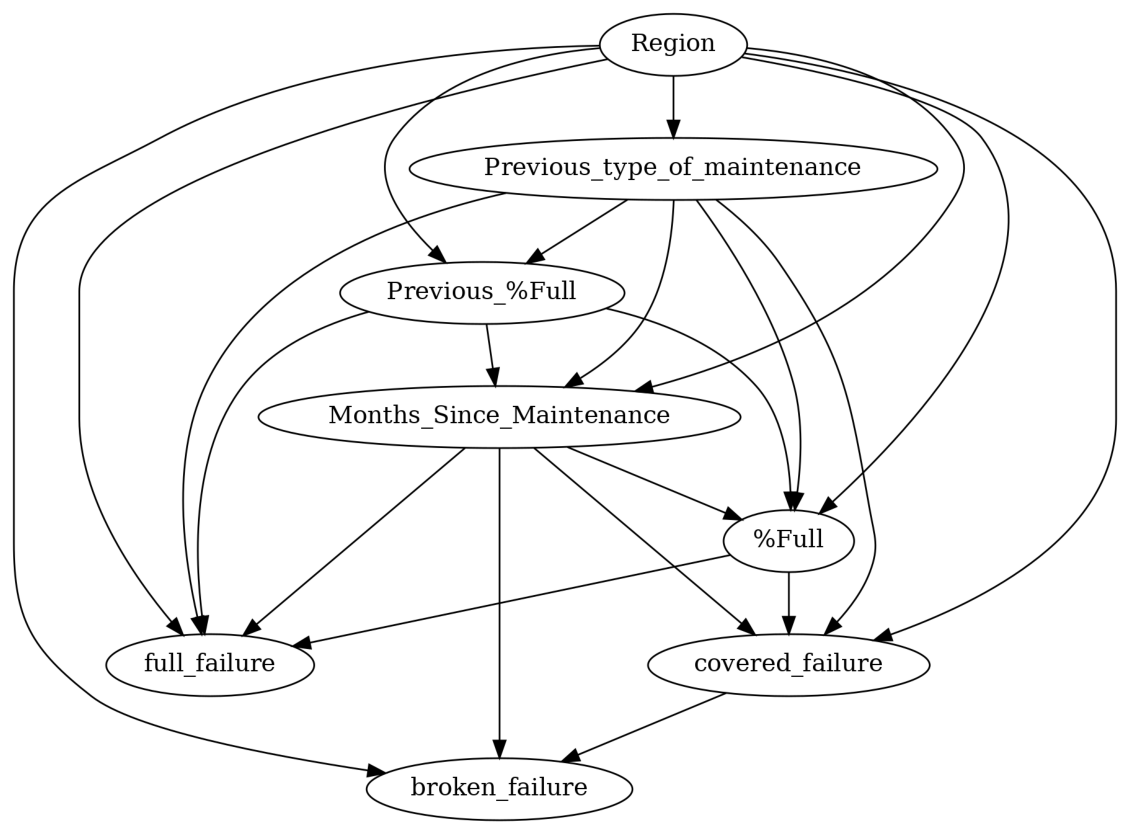

In [183]:
# visualization using pydot
pyd = GraphUtils.to_pydot(dag,labels=list(struct_data.columns.values))
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.figure(figsize = (20,20))
plt.axis('off')
plt.imshow(img)
plt.show()

pyd.write_png('human_intuition.png')

In [168]:
dag.get_graph_edges()

In [170]:
edges = dag.get_graph_edges()

for edge in edges:
    print([edge.get_node1().name,edge.get_numerical_endpoint1(),edge.get_node2().name,edge.get_numerical_endpoint2()])

['Region', -1, '%Full', 1]
['%Full', -1, 'full_failure', 1]
['%Full', -1, 'covered_failure', 1]
['Previous_%Full', -1, '%Full', 1]
['Previous_type_of_maintenance', -1, '%Full', 1]
['Months_Since_Maintenance', -1, '%Full', 1]
['Region', -1, 'full_failure', 1]
['Region', -1, 'covered_failure', 1]
['Region', -1, 'broken_failure', 1]
['Region', -1, 'Previous_%Full', 1]
['Region', -1, 'Previous_type_of_maintenance', 1]
['Region', -1, 'Months_Since_Maintenance', 1]
['Previous_%Full', -1, 'full_failure', 1]
['Previous_type_of_maintenance', -1, 'full_failure', 1]
['Months_Since_Maintenance', -1, 'full_failure', 1]
['covered_failure', -1, 'broken_failure', 1]
['Previous_type_of_maintenance', -1, 'covered_failure', 1]
['Months_Since_Maintenance', -1, 'covered_failure', 1]
['Months_Since_Maintenance', -1, 'broken_failure', 1]
['Previous_type_of_maintenance', -1, 'Previous_%Full', 1]
['Previous_%Full', -1, 'Months_Since_Maintenance', 1]
['Previous_type_of_maintenance', -1, 'Months_Since_Maintenanc

## attempt with categorical data

In [49]:
data["Months_Since_maintenance"] = data["Days_Since_Maintenance"].apply(reduce_cardinality_of_dsm)

In [81]:
data = data.drop(columns="Days_Since_Maintenance")

'<i8'

In [79]:
for dtype, name in zip(data.dtypes,data.columns):
    if str(dtype) == 'int64':
        data[name] = data[name].apply(lambda x: "True" if x ==1 else "False")

In [85]:
data["RouteID"] = data["RouteID"].apply(lambda x: "a" + str(x))

In [88]:
data

,FloodHotspot,RouteID,ParameterValueID,prefix,full_failure,covered_failure,broken_failure,Previous_pvalue,Months_Since_maintenance
15458,False,a1101,0-25,NW13,False,False,False,0-25,None
15460,False,a1101,2550,NW13,False,False,False,2550,None
15462,False,a1101,2550,NW13,False,False,False,2550,None
15464,False,a1101,2550,NW13,False,False,False,2550,None
15466,True,a1101,2550,NW13,False,False,False,2550,None
...,...,...,...,...,...,...,...,...,...
551199,False,aM016,7510,NW10,False,False,False,2550,6-9
551200,False,aM016,7510,NW10,False,False,False,2550,6-9
551201,True,aM501,2550,SW21,False,False,False,5075,6-9
551202,True,aM501,2550,SW21,False,False,False,5075,6-9


In [95]:
test_data= data.to_numpy()

In [101]:
np.isnan(["a","b","8"])

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [96]:
from causallearn.search.ConstraintBased.PC import pc

# default parameters
cg = pc(test_data,stable=True)

# or customized parameters
# visualization using pydot
cg.draw_pydot_graph()

# or save the graph
from causallearn.utils.GraphUtils import GraphUtils

pyd = GraphUtils.to_pydot(cg.G)
pyd.write_png('simple_test.png')

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [81]:
# Generate the true causal DAG
true_dag = DAG.scale_free(n_nodes=10, n_edges=15, seed=18)


DATA_PARAMS = {
    'linearity': ['linear', 'nonlinear'], 
    'distribution': {
        'linear': ['gauss', 'exp'],
        'nonlinear': ['quadratic']
    }
}

datasets = {}

for linearity in DATA_PARAMS['linearity']:
    for distr in DATA_PARAMS['distribution'][linearity]:
        
        datasets[f'{linearity}_{distr}'] = IIDSimulation(
            W=true_dag, 
            n=2000, 
            method=linearity, 
            sem_type=distr)
            
print(datasets)

{'linear_gauss': <castle.datasets.simulator.IIDSimulation object at 0x7f45a12bb8b0>, 'linear_exp': <castle.datasets.simulator.IIDSimulation object at 0x7f45a91285b0>, 'nonlinear_quadratic': <castle.datasets.simulator.IIDSimulation object at 0x7f45a1b5f220>}


In [90]:
golem = GOLEM()

************* Current dataset: linear_gauss

Method: PC


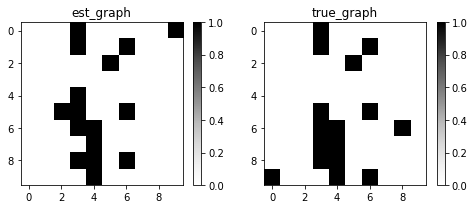

FDR: 0.2
Recall: 0.75
Precision: 0.75
F1 score: 0.75
-------------------------------------------------- 

Method: GES


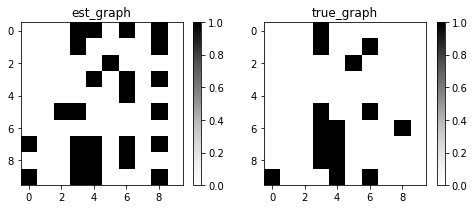

FDR: 0.5833
Recall: 0.625
Precision: 0.3846
F1 score: 0.4762
-------------------------------------------------- 

Method: LiNGAM


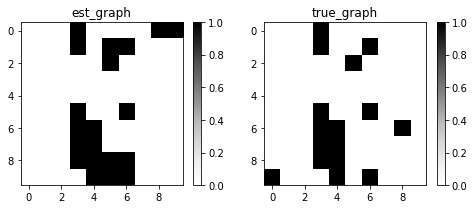

FDR: 0.3
Recall: 0.875
Precision: 0.7
F1 score: 0.7778
-------------------------------------------------- 

Method: GOLEM


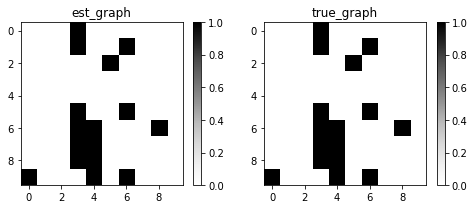

FDR: 0.0
Recall: 1.0
Precision: 1.0
F1 score: 1.0
-------------------------------------------------- 



************* Current dataset: linear_exp

Method: PC


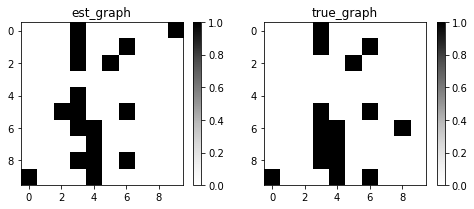

FDR: 0.1875
Recall: 0.8125
Precision: 0.7222
F1 score: 0.7647
-------------------------------------------------- 

Method: GES


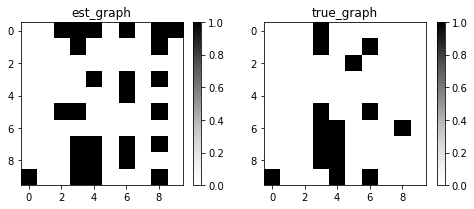

FDR: 0.625
Recall: 0.5625
Precision: 0.3462
F1 score: 0.4286
-------------------------------------------------- 

Method: LiNGAM


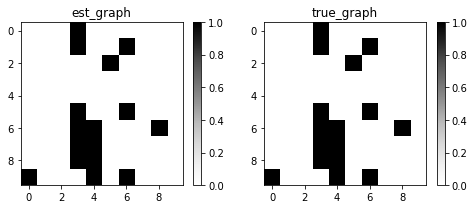

FDR: 0.0
Recall: 1.0
Precision: 1.0
F1 score: 1.0
-------------------------------------------------- 

Method: GOLEM


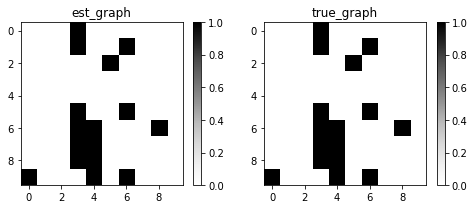

FDR: 0.0
Recall: 1.0
Precision: 1.0
F1 score: 1.0
-------------------------------------------------- 



************* Current dataset: nonlinear_quadratic

Method: PC


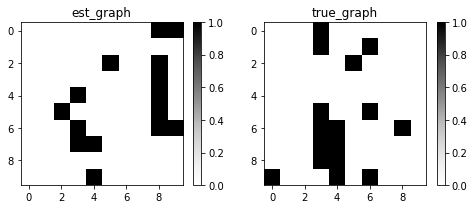

FDR: 0.5714
Recall: 0.375
Precision: 0.4
F1 score: 0.3871
-------------------------------------------------- 

Method: GES


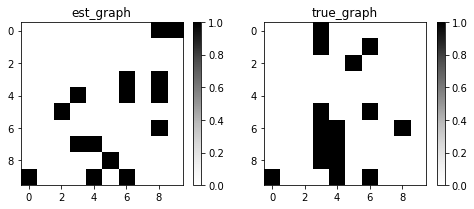

FDR: 0.5714
Recall: 0.375
Precision: 0.4
F1 score: 0.3871
-------------------------------------------------- 

Method: LiNGAM


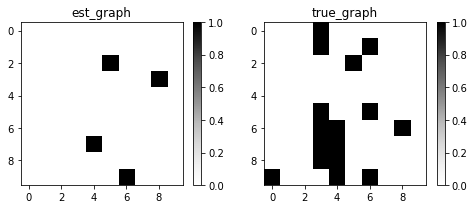

FDR: 0.25
Recall: 0.1875
Precision: 0.75
F1 score: 0.3
-------------------------------------------------- 

Method: GOLEM


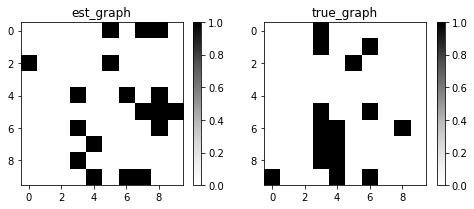

FDR: 0.6111
Recall: 0.4375
Precision: 0.3889
F1 score: 0.4118
-------------------------------------------------- 





In [86]:
methods = OrderedDict({
    'PC': PC,
    'GES': GES,
    'LiNGAM': ICALiNGAM,
    'GOLEM': GOLEM
})


results = {}

# Iterate over datasets
for k, dataset in datasets.items():
    print(f'************* Current dataset: {k}\n')
    X = dataset.X
    
    results[dataset] = {}
    
    # Iterate over algorithms
    for method in methods:
        print(f'Method: {method}')

        # Instantiate the model
        if method == 'GOLEM':
            model = methods[method](num_iter=2.5e4)
        else:
            model = methods[method]()
        
        # Fit the model
        model.learn(X)
        
        # Get the DAG
        pred_dag = model.causal_matrix
              
        # Get n undir edges
        #n_undir = model.get_n_undirected(pred_dag)

        # Plot results
        GraphDAG(pred_dag, true_dag, 'result')

        mt = MetricsDAG(pred_dag, true_dag)
        print(f'FDR: {mt.metrics["fdr"]}')
        print(f'Recall: {mt.metrics["recall"]}')
        print(f'Precision: {mt.metrics["precision"]}')
        print(f'F1 score: {mt.metrics["F1"]}')
        #print(f'No. of undir. edges: {n_undir}\n')
        print('-' * 50, '\n')

        results[dataset][method] = pred_dag      
            
    print('\n') 